In [11]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import math

from collections import Counter
import time
import sys
from datetime import datetime as dt

import nltk
from nltk.corpus import gutenberg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Drill: tf-idf scores

In [6]:
df = pd.DataFrame()
df['word'] = ['Monty', 'Python', 'sketch', 'laugh', 'funny', 'best', 'ice cream', 
              'dessert', 'taste']
N = 3
df['cf'] = [1, 1, 0, 1, 1, 1, 2, 1, 3]
df['df'] = [1, 1, 0, 1, 1, 1, 2, 1, 2]
df['idf'] = [ (math.log2(N/x) if x != 0 else 0) for x in df['df']]
df['tf1'] = [1, 1, 0, 1, 1, 0, 0, 0, 0]
df['tf2'] = [0, 0, 0, 0, 0, 1, 1, 1, 1]
df['tf3'] = [0, 0, 0, 0, 0, 0, 1, 0, 2]
df['tf-idf1'] = [ x*y for x,y in zip(df['idf'], df['tf1'])]
df['tf-idf2'] = [ x*y for x,y in zip(df['idf'], df['tf2'])]
df['tf-idf3'] = [ x*y for x,y in zip(df['idf'], df['tf3'])]

In [7]:
df.head(12)

,word,cf,df,idf,tf1,tf2,tf3,tf-idf1,tf-idf2,tf-idf3
0,Monty,1,1,1.584963,1,0,0,1.584963,0.000000,0.000000
1,Python,1,1,1.584963,1,0,0,1.584963,0.000000,0.000000
2,sketch,0,0,0.000000,0,0,0,0.000000,0.000000,0.000000
3,laugh,1,1,1.584963,1,0,0,1.584963,0.000000,0.000000
4,funny,1,1,1.584963,1,0,0,1.584963,0.000000,0.000000
5,best,1,1,1.584963,0,1,0,0.000000,1.584963,0.000000
6,ice cream,2,2,0.584963,0,1,1,0.000000,0.584963,0.584963
7,dessert,1,1,1.584963,0,1,0,0.000000,1.584963,0.000000
8,taste,3,2,0.584963,0,1,2,0.000000,0.584963,1.169925


# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?

In [8]:
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    emma_paras.append(' '.join(para))

In [9]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [14]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the testing data, then project the testing data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 49.36851695387824
Component 0:
" Me ! oh !    0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh no !      0.999921
" Oh no !      0.999921
" Oh !         0.999921
" Oh !         0.999921
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.615316
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                               

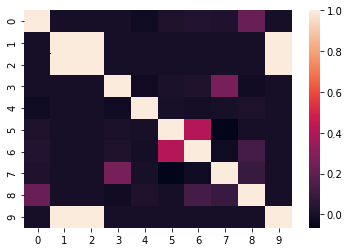

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [15]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## conclusion of Drill 0:  

The answer is no. 

## Drill 1